# Exercise 14

## Predict rating using LSTM


In [1]:
import pandas as pd

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [3]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [4]:
plots

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [5]:
plots[2582]

"in los angeles ,  the editor of a publishing house carol hunnicut goes to a blind date with the lawyer michael tarlow ,  who has embezzled the powerful mobster leo watts .  carol accidentally witnesses the murder of michel by leo ' s hitman .  the scared carol sneaks out of michael ' s room and hides in an isolated cabin in canada .  meanwhile the deputy district attorney robert caulfield and sgt .  dominick benti discover that carol is a witness of the murder and they report the information to caulfield ' s chief martin larner and they head by helicopter to canada to convince carol to testify against leo .  however they are followed and the pilot and benti are murdered by the mafia .  caulfield and carol flees and they take a train to vancouver .  caulfield hides carol in his cabin and he discloses that there are three hitman in the train trying to find carol and kill her .  but they do not know her and caulfield does not know who might be the third killer from the mafia and who has 

In [6]:
y

3107    1
900     0
6724    1
4704    1
2582    1
       ..
8417    0
1592    0
1723    0
7605    1
215     1
Name: rating, Length: 7895, dtype: int64

In [7]:
dataTraining.dtypes

year        int64
title      object
plot       object
genres     object
rating    float64
dtype: object

# Exercise 14.1

- Remove stopwords 
- Lowercase
- split the text in words 
- pad_sequences

In [8]:
import string
import re
def clean_text(article):
    clean1 = re.sub(r'['+string.punctuation + '’—”'+']', "", article.lower())
    return re.sub(r'\W+', ' ', clean1)

In [9]:
dataTraining['tockenized'] = dataTraining['plot'].map(lambda x: clean_text(x))

In [10]:
X = dataTraining['tockenized'].tolist()
X[4]

'in los angeles the editor of a publishing house carol hunnicut goes to a blind date with the lawyer michael tarlow who has embezzled the powerful mobster leo watts carol accidentally witnesses the murder of michel by leo s hitman the scared carol sneaks out of michael s room and hides in an isolated cabin in canada meanwhile the deputy district attorney robert caulfield and sgt dominick benti discover that carol is a witness of the murder and they report the information to caulfield s chief martin larner and they head by helicopter to canada to convince carol to testify against leo however they are followed and the pilot and benti are murdered by the mafia caulfield and carol flees and they take a train to vancouver caulfield hides carol in his cabin and he discloses that there are three hitman in the train trying to find carol and kill her but they do not know her and caulfield does not know who might be the third killer from the mafia and who has betrayed him in his office '

In [11]:
def four_pounds_tokenizer(s):
   return s.split('####')

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words = 'english', tokenizer = four_pounds_tokenizer)
X_dtm = vect.fit_transform(X)

In [12]:
v = vect.get_feature_names()
voc = set((' '.join(v)).split())
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [13]:
X1 = [x.split() for x in v]
len_ = pd.Series([len(x) for x in X1])

In [14]:
len_.describe()

count    7893.000000
mean      126.630685
std        84.399123
min         1.000000
25%        70.000000
50%       110.000000
75%       161.000000
max      1723.000000
dtype: float64

In [15]:
# Max len
max_doc_len = 161
X = [x[:max_doc_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [16]:
len(X)

7895

In [17]:
from keras.preprocessing import sequence
X_pad = sequence.pad_sequences(X, maxlen = max_doc_len)
X_pad

Using TensorFlow backend.


array([[    0,     0,     0, ..., 33151, 28344,  9854],
       [    0,     0,     0, ...,  9854, 14775,  2842],
       [    0,     0,     0, ..., 21358,  5298,  6815],
       ...,
       [    0,     0,     0, ..., 28344,  9854,  6815],
       [    0,     0,     0, ...,  6815, 19490, 21358],
       [    0,     0,     0, ..., 14775,  9854,  9854]], dtype=int32)

# Exercise 14.2

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [18]:
import keras
from keras import backend as K

In [19]:
!pip install livelossplot
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [20]:
from livelossplot import PlotLossesKeras
%matplotlib inline

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.33, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5289, 161) (5289,)
(2606, 161) (2606,)


In [22]:
from keras.optimizers import SGD
opt = SGD(lr=0.001)

#Initializing the classifier Network
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length = max_doc_len))

#Adding the input LSTM network layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

#Adding a second LSTM network layer
model.add(LSTM(64))

#Adding the output layer
model.add(Dense(1, activation = 'sigmoid'))

#Compiling the network
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 161, 128)          4954496   
_________________________________________________________________
lstm_1 (LSTM)                (None, 161, 64)           49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 161, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,036,993
Trainable params: 5,036,993
Non-trainable params: 0
_________________________________________________________________


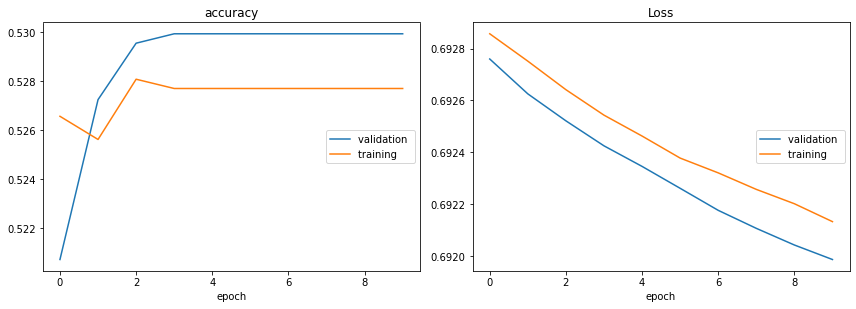

accuracy
	validation       	 (min:    0.521, max:    0.530, cur:    0.530)
	training         	 (min:    0.526, max:    0.528, cur:    0.528)
Loss
	validation       	 (min:    0.692, max:    0.693, cur:    0.692)
	training         	 (min:    0.692, max:    0.693, cur:    0.692)


In [23]:
model.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size = 128, epochs = 10, verbose = 1,
          callbacks=[PlotLossesKeras()])

In [24]:
score, acc = model.evaluate(X_test, y_test, verbose = 1, batch_size = 128)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

2606/2606 [==============================] - 1s 353us/step
Score: 0.69
Validation Accuracy: 0.53
